# Project: Counterfeit detection

## Context

A national French public organisation called ONCFM (national organisation against counterfeit money) needs us to come up with an algorithm able to automatically detect legit from counterfeit bills.

## Notes & overview

We will first use **Linear Regression** to predict some missing values, then we will try two ML algorithms to predict weither new examples would be legit or counterfeit bills: **Logistc Regression** as well as **K-Means Clustering for Classification**.

### [Specifications (in French)](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/DAN-P10-cdc-detection-faux-billets.pdf)

## Summary
 - [1. Libraries import](#1)
 - [2. Databases import](#2)
 - [3. Data exploration](#3)
 - [4. Linear Regression](#4)
   - [4.1 Model training](#4.1)
   - [4.2 Prediction of the missing values](#4.2)
 - [5. Logistic Regression](#5)
   - [5.1 Model training](#5.1)
   - [5.2 Prediction on test dataset](#5.2)
 - [6. K-Means Clustering for Classification](#6)
   - [6.1 Model training](#6.1)
   - [6.2 Prediction on test dataset](#6.2)
 - [7. Final application](#7)

<a name="1"></a>
## 1. Libraries import

We first import the libraries we will need throughout this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%pylab inline
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


<a name="2"></a>
## 2. Databases import

`data` is the database given to us by the ONCFM.

`data_test` is another file given to us by the ONCFM as a format example of how the data on which the algorithm will perform looks. We can use this file as a *test set*.

In [2]:
data = pd.read_csv('billets.csv', sep=';')
data_test = pd.read_csv('billets_production.csv', sep=',')

<a name="3"></a>
## 3. Data exploration

Let's have an idea about what the data looks like:

In [3]:
#pd.set_option('display.max_rows', None) # To show all rows
pd.set_option('display.max_rows', 10) # To only show 10 rows
display(data)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


The data contains 1000 examples of left bills and 500 examples of counterfeit ones.

I like to display a correlation matrix to see if there are any correlated variables. It does not seem to be the case.

In [4]:
corrMatrix = data.corr()
display(corrMatrix)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


I also like to use `.info()` to see if there are any missing values:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


We can see that the column *margin_low* has 37 missing values. We don't really like NaNs, so we will first use a linear regression model using the ML library scikit-learn to "predict" these values so that we don't have missing values anymore.

Note that we could also just delete these lines since there are only a few, or use another mean to fill these values, such as the mean of all the other examples.

I decided to split the legit bills from the counterfeit bills since we wouldn't want to predict the *margin_low* values from the legit bills with data containing data from counterfeit ones.

In [6]:
data_true = data[data['is_genuine'] == True]
data_false = data[data['is_genuine'] == False]

print('Legit bills:', data_true.shape)
print('Counterfeit bills:', data_false.shape)

Legit bills: (1000, 7)
Counterfeit bills: (500, 7)


Legit bills:

In [7]:
display(data_true.head())
data_true.info() # 29 margin_low missing values

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1000 non-null   bool   
 1   diagonal      1000 non-null   float64
 2   height_left   1000 non-null   float64
 3   height_right  1000 non-null   float64
 4   margin_low    971 non-null    float64
 5   margin_up     1000 non-null   float64
 6   length        1000 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 55.7 KB


Counterfeit bills:

In [8]:
display(data_false.head())
data_false.info() # 8 missing margin_low values

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1000,False,172.28,103.95,103.91,4.78,3.31,111.40
1001,False,171.92,103.86,104.30,4.96,3.13,111.29
1002,False,171.59,104.14,104.38,4.97,3.47,111.22
1003,False,172.02,104.33,104.33,5.19,3.21,111.99
1004,False,172.55,104.25,104.23,5.60,3.13,111.72


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    500 non-null    bool   
 1   diagonal      500 non-null    float64
 2   height_left   500 non-null    float64
 3   height_right  500 non-null    float64
 4   margin_low    492 non-null    float64
 5   margin_up     500 non-null    float64
 6   length        500 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 27.8 KB


We can actually visually see that the data from the counterfeit bills *looks* different than the legit ones.

### Check for outliers

It's always nice to check our data for any potentially disrupting outliers:

In [9]:
def Outliers(i):
    """ Displays a boxplot and a list of the outliers of the input variable """
    print()
    print("Boxplot :", i)
    box = boxplot(data[i])
    plt.show()
    print()
    print("Outliers list:")
    top_points = box["fliers"][0].get_data()[1]
    display(pd.DataFrame(data[i][data[i].isin(top_points)]).sort_values(by = i, ascending=False))

#for column in data.columns[1:]:
#    Outliers(column)

Even though there are outliers, there do not seem to be extreme ones.

Note: We can already see that having NaNs in our database is not a great thing: the boxplot() function didn't work on *margin_low* since it contains NaN values.

<a name="4"></a>
## 4. Linear Regression

<a name="4.1"></a>
### 4.1 Model preparation

As we said before, let's predict missing values using linear regression.

**Note: We will do so for both legit and counterfeit bills to keep a clean dataset, but we could argue than doing so for the counterfeit ones is not pertinent.**

Let's first split the examples with the values we want to predict from the original dataset.

In [10]:
data_true_null = data_true[data_true["margin_low"].isnull()]
data_false_null = data_false[data_false["margin_low"].isnull()]

data_true_without_null = data_true[data_true["margin_low"].notnull()]
data_false_without_null = data_false[data_false["margin_low"].notnull()]

In [11]:
print('Legit bills with missing margin_low:', data_true_null.shape)
print('Counterfeit bills with missing margin_low:', data_false_null.shape)
print()
print('Full data legit bills:', data_true_without_null.shape)
print('Full data counterfeit bills:', data_false_without_null.shape)

Legit bills with missing margin_low: (29, 7)
Counterfeit bills with missing margin_low: (8, 7)

Full data legit bills: (971, 7)
Full data counterfeit bills: (492, 7)


We can visualize the data with seaborn:

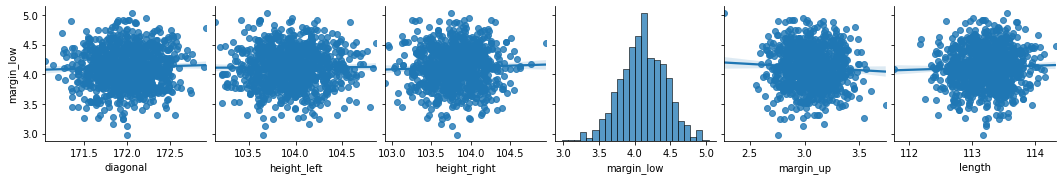

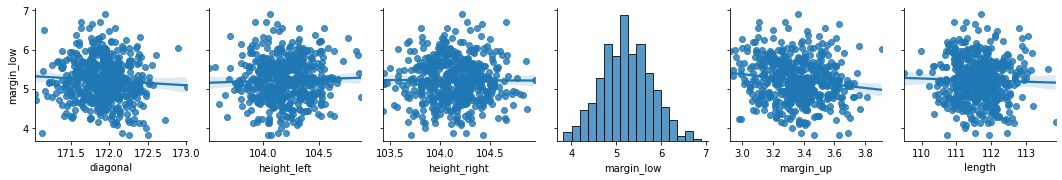

In [12]:
sns.pairplot(data_true_without_null, x_vars=["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"], y_vars="margin_low", kind='reg')
sns.pairplot(data_false_without_null, x_vars=["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"], y_vars="margin_low", kind='reg')

We first assign X and y for linear regression:

In [13]:
feature_cols = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

X_true = data_true_without_null[feature_cols]
X_false = data_false_without_null[feature_cols]

y_true = data_true_without_null['margin_low']
y_false = data_false_without_null['margin_low']

Then split the data between *training* and *cross-validation* (which I called *test* in this notebook) sets.

In [14]:
X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X_true, y_true)
X_false_train, X_false_test, y_false_train, y_false_test = train_test_split(X_false, y_false)

We train the models:

In [15]:
linreg_true = LinearRegression()
linreg_false = LinearRegression()

linreg_true.fit(X_true_train, y_true_train)
linreg_false.fit(X_false_train, y_false_train)

LinearRegression()

Let's print some useful informations: the coefficients.

In [16]:
print(linreg_true.intercept_)
print(linreg_false.intercept_)
print()
print(linreg_true.coef_)
print(linreg_false.coef_)

zip(feature_cols, linreg_true.coef_)
zip(feature_cols, linreg_false.coef_)

-12.951126603929994
11.144882636178854

[ 0.04401402  0.02760476  0.02975377 -0.05957221  0.03289316]
[-0.12127598  0.23179017 -0.00864829 -0.35688165 -0.06375586]


Predictions of the trained models on the *test sets*:

In [17]:
y_true_pred = linreg_true.predict(X_true_test)
y_false_pred = linreg_false.predict(X_false_test)

print(y_true_pred)
print(y_false_pred)

[4.10093021 4.13719273 4.09451289 4.1090038  4.12343391 4.13190758
 4.0944275  4.13483691 4.12049022 4.09477924 4.11088954 4.11694839
 4.08424418 4.14433829 4.11299804 4.05897758 4.1182746  4.14118527
 4.14053464 4.13640794 4.12427159 4.14540798 4.13032926 4.10380766
 4.11315708 4.08052304 4.1279743  4.15555985 4.14029612 4.10947878
 4.13665809 4.10994449 4.07057872 4.12815388 4.13596275 4.11661104
 4.12124942 4.10370814 4.08928872 4.09552407 4.15460008 4.11363597
 4.09965753 4.0691673  4.13466562 4.14101876 4.12606754 4.08743677
 4.16834649 4.13428972 4.1043705  4.14622613 4.10464874 4.11040283
 4.13531428 4.09672869 4.17681104 4.09647764 4.11026559 4.09899805
 4.10682147 4.13327493 4.10981922 4.1308694  4.1117448  4.13262679
 4.07631185 4.08826989 4.10617771 4.1629225  4.09860748 4.11933063
 4.14394583 4.11205262 4.10680439 4.10773591 4.11421611 4.09357762
 4.14231933 4.11689441 4.08015525 4.17919661 4.097974   4.12188524
 4.08372698 4.13402471 4.12120451 4.10990929 4.08662411 4.1161

We can note that the predicted values for the counterfeit bills are quite different than the predicted values for the legit ones. This seems logical since we noted before during the data exploration that the values from the counterfeit bills already looked different.

Let's evaluate the models:

In [18]:
print()
print('Legit bills:')
print(metrics.mean_absolute_error(y_true_test, y_true_pred))
print(metrics.mean_squared_error(y_true_test, y_true_pred))
print(np.sqrt(metrics.mean_squared_error(y_true_test, y_true_pred)))

print()
print('Counterfeit bills:')
print(metrics.mean_absolute_error(y_false_test, y_false_pred))
print(metrics.mean_squared_error(y_false_test, y_false_pred))
print(np.sqrt(metrics.mean_squared_error(y_false_test, y_false_pred)))


Legit bills:
0.26585221113464585
0.1129265039405479
0.3360453897028613

Counterfeit bills:
0.48290066389652053
0.34297071177035654
0.5856370136614971


<a name="4.2"></a>
### 4.2 Prediction of the missing values

Now that we trained our models, we can use them to "predict" our missing values.

In [19]:
print()
print('Legit bills:')

data_true_pred = data_true_null[feature_cols]
pred_true = linreg_true.predict(data_true_pred)
print(pred_true)


print()
print('Counterfeit bills:')

data_false_pred = data_false_null[feature_cols]
pred_false = linreg_false.predict(data_false_pred)
print(pred_false)



Legit bills:
[4.07893861 4.12127953 4.12815365 4.05518346 4.0987056  4.06865649
 4.10326373 4.11854901 4.11632701 4.10054665 4.12454947 4.15009427
 4.14645284 4.06683584 4.11018063 4.13344992 4.10342525 4.08677554
 4.11741444 4.13894018 4.15206782 4.13660816 4.1572971  4.09425731
 4.12779805 4.14144961 4.09685543 4.09593453 4.13444566]

Counterfeit bills:
[5.32513797 5.3545361  5.38082867 5.45125279 5.14322246 5.31046063
 5.10770777 5.30225282]


### Complete dataframe with missing values

We can now add these predicted values to our original dataset.

Note: Naming databases and variables is not my strong suit :)

In [20]:
data_true2 = data_true.copy(deep=True)
data_true2.loc[data_true2['margin_low'].isnull(), 'margin_low'] = pred_true

data_false2 = data_false.copy(deep=True)
data_false2.loc[data_false2['margin_low'].isnull(), 'margin_low'] = pred_false

frames = (data_true2, data_false2)
data2 = pd.concat(frames)

display(data2)
data2.info()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


There are no more missing values in our 1500 lines database!

Now let's get the fun started ;)

<a name="5"></a>
## 5. Logistic Regression

We will first try using a logistic regression for our counterfeit detection application.

We are again using the scikit-learn librairy, and the process for logistic regression is quite similar than for linear regression.

<a name="5.1"></a>
### 5.1 Model training

We assign X and y:

In [21]:
feature_cols_log = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X_log = data2[feature_cols_log]

data2['is_genuine'] = data2['is_genuine'].astype('category')
y_log = data2['is_genuine'].cat.codes

Separation between *training* and *test* sets:

In [22]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.3, random_state=0)

Model training:

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train_log, y_train_log)

LogisticRegression()

Predictions of the trained model on the test set:

In [24]:
y_pred_log = logreg.predict(X_test_log)
print(y_pred_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_log, y_test_log)))

[1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1
 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1
 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1
 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0
 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0
 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1
 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0
 0 0 0 0 0 1]
Accuracy of logistic regression classifier on test set: 1.00


### Confusion matrix

In [25]:
matrice_de_confusion_log = confusion_matrix(y_test_log, y_pred_log)
display(pd.DataFrame(matrice_de_confusion_log))

print(classification_report(y_test_log, y_pred_log))

,0,1
0,156,1
1,0,293


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       157
           1       1.00      1.00      1.00       293

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



<a name="5.2"></a>
### 5.2 Predictions on test dataset

We're testing our model on the test dataset given by the ONCFM (the *test* dataset we used to test our trained model on before could be called the *cross-validation* set).

In [26]:
display(data_test)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [27]:
data_test2 = data_test[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]]

pred_log = logreg.predict(data_test2)

print(pred_log) # 0 == counterfeit bill, 1 == legit bill

[0 0 0 1 1]


The results seem accurate, we can visally see than the predicted counterfeit bills correspond to the examples with unusual high values for *margin_low*.

<a name="6"></a>
## 6. K-Means Clustering for Classification

We will now try our luck using a K-means classification model.

We are still using the scikit-learn library.

<a name="6.1"></a>
### 6.1 Model training

We assign X and y:

In [28]:
feature_cols_km = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X_km = data2[feature_cols_km]

y_km = data2['is_genuine'].cat.codes

Separate the data between *training* and *test*:

In [29]:
X_train_km, X_test_km, y_train_km, y_test_km = train_test_split(X_km, y_km, test_size=0.3, random_state=0)

Now we train the model. Note that `random_state` is used so that we don't end up with our clusters randomly named 0 or 1, which is inconsistent.

In [30]:
kmeans = KMeans(n_clusters=2, random_state =42)
kmeans.fit(X_train_km, y_train_km)

KMeans(n_clusters=2, random_state=42)

And predict on our *test dataset*:

In [31]:
y_pred_km = kmeans.predict(X_test_km)
print(y_pred_km)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_km, y_test_km)))

[0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0
 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1
 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1
 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0
 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1
 1 1 1 1 1 0]
Accuracy of logistic regression classifier on test set: 1.00


### Confusion matrix

In [32]:
matrice_de_confusion_km = confusion_matrix(y_test_km, y_pred_km)
display(pd.DataFrame(matrice_de_confusion_log))

print(classification_report(y_test_km, y_pred_km))

,0,1
0,156,1
1,0,293


              precision    recall  f1-score   support

           0       0.01      0.02      0.01       157
           1       0.00      0.00      0.00       293

    accuracy                           0.01       450
   macro avg       0.01      0.01      0.01       450
weighted avg       0.00      0.01      0.00       450



<a name="6.2"></a>
### 6.2 Predictions on test dataset

In [33]:
pred_km = kmeans.predict(data_test2)

print(pred_km) # 0 == legit bill, 1 == counterfeit bill

[1 1 1 0 0]


Note that now, the legit bills are labeled `0` and the counterfeit bills `1`.

We can display the cluster centroids for our information:

In [34]:
print(kmeans.cluster_centers_)

[[171.9764779  103.95455801 103.81372928   4.13044434   3.05947514
  113.18551105]
 [171.89174847 104.19199387 104.14610429   5.24335871   3.34273006
  111.58306748]]


<a name="7"></a>
## 7. Final application

Let's write clean functions so that we can use our logistic regression and K-Means classification algorithms for any new dataset (as long as it respects the same format as the `test_dataset`)

In [35]:
def logistic_regression(data):
    """Applies logistic regression on input data"""
    print("Counterfeit bill detection using Logistic Regression...")
    print()
    data2 = data[feature_cols_log]
    prediction = logreg.predict(data2)
    data['Prediction'] = prediction
    data.loc[data.Prediction == 0, "Prediction"] = "Counterfeit bill"
    data.loc[data.Prediction == 1, "Prediction"] = "Legit bill"
    return data


def k_means_classification(data):
    """Applies K-Means classification on input data"""
    print("Counterfeit bill detection using K-Means Classification...")
    print()
    data2 = data[feature_cols_km]
    prediction = kmeans.predict(data2)
    data['Prediction'] = prediction
    data.loc[data.Prediction == 0, "Prediction"] = "Legit bill"
    data.loc[data.Prediction == 1, "Prediction"] = "Counterfeit bill"
    return data

In [36]:
data_test_reg = data_test.copy(deep=True)
data_test_km = data_test.copy(deep=True)

In [37]:
logistic_regression(data_test_reg)

Counterfeit bill detection using Logistic Regression...



,diagonal,height_left,height_right,margin_low,margin_up,length,id,Prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,Counterfeit bill
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,Counterfeit bill
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,Counterfeit bill
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,Legit bill
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,Legit bill


In [38]:
k_means_classification(data_test_km)

Counterfeit bill detection using K-Means Classification...



,diagonal,height_left,height_right,margin_low,margin_up,length,id,Prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,Counterfeit bill
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,Counterfeit bill
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,Counterfeit bill
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,Legit bill
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,Legit bill
